In [1]:
from function.graph import * # fichier qui regroupe les fonctions pour faire les graphes
from function.follow import *  # fichier qui regroupe les fonctions sur les follows
from function.hashtags import * # fichier qui regoupe les fonctions pour analyser les hashtags
from function.figure import *
from function.recover import get_dataframe_from_table
from function.preprocessing import *
import community
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import umap

In [2]:
data=get_frensh_tweets_dataframe("tweets_0415_0423",700) 


MySQL connection is closed


# Preprocessing text

In [3]:
tweets = data["text"].values
new_tweets=preprocessing(tweets)


# **Vectorisation des données**

In [6]:
k=10

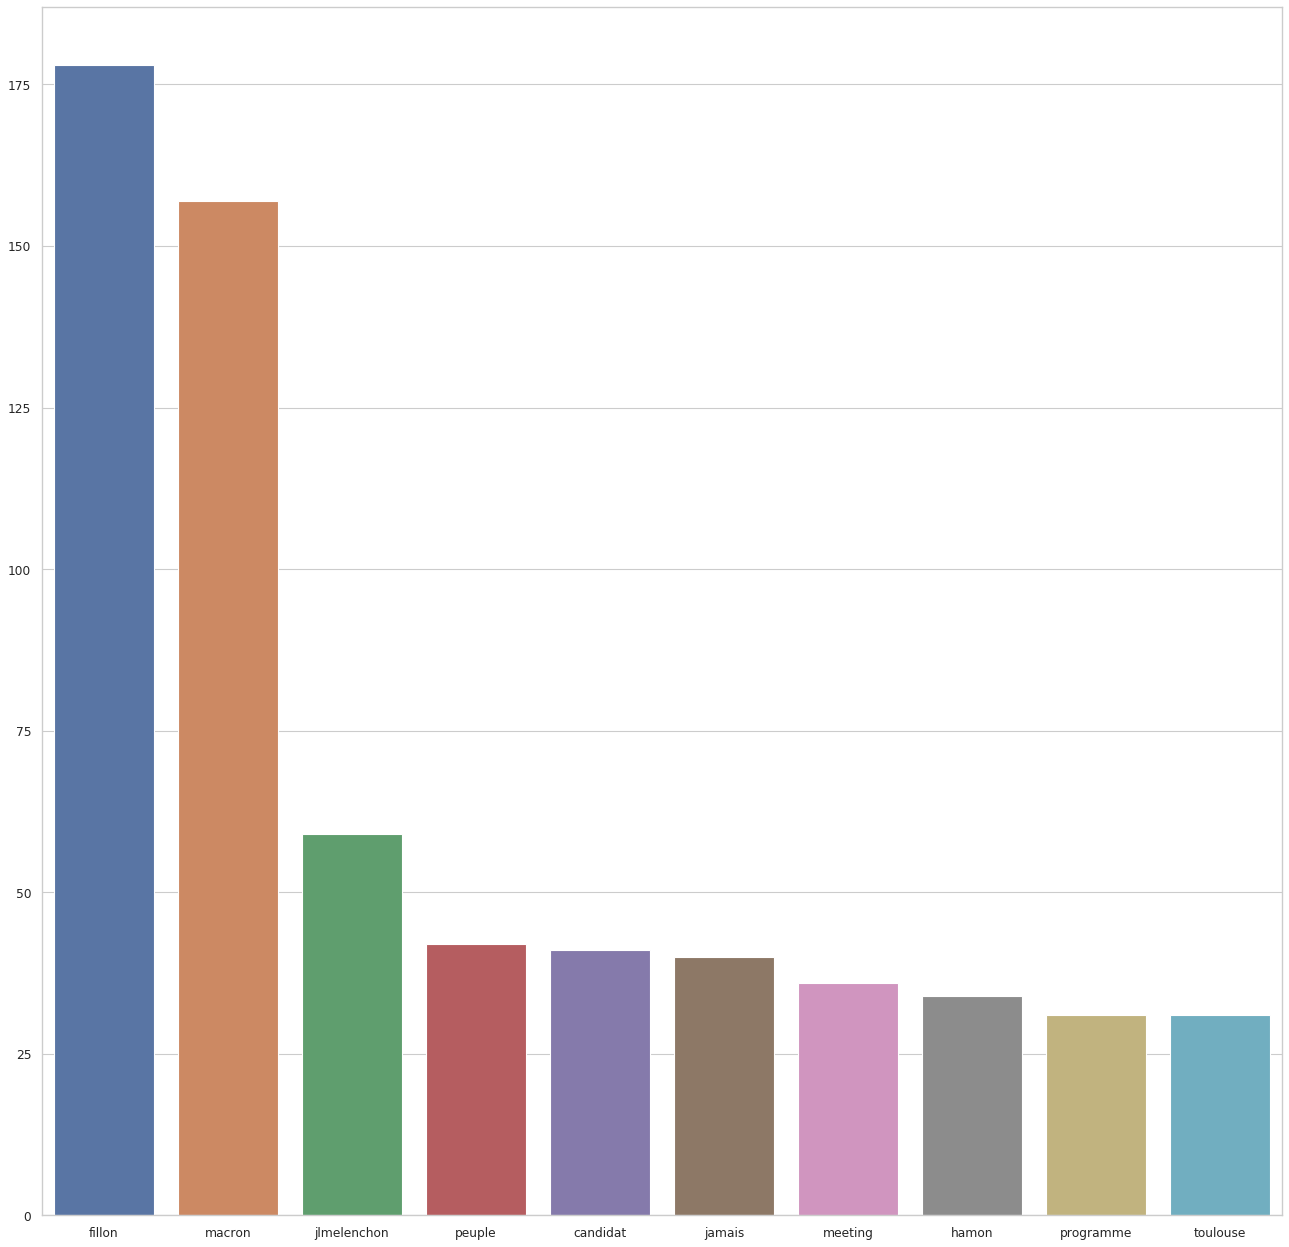

In [7]:
histogramme_vectorised_data(new_tweets,1,k)

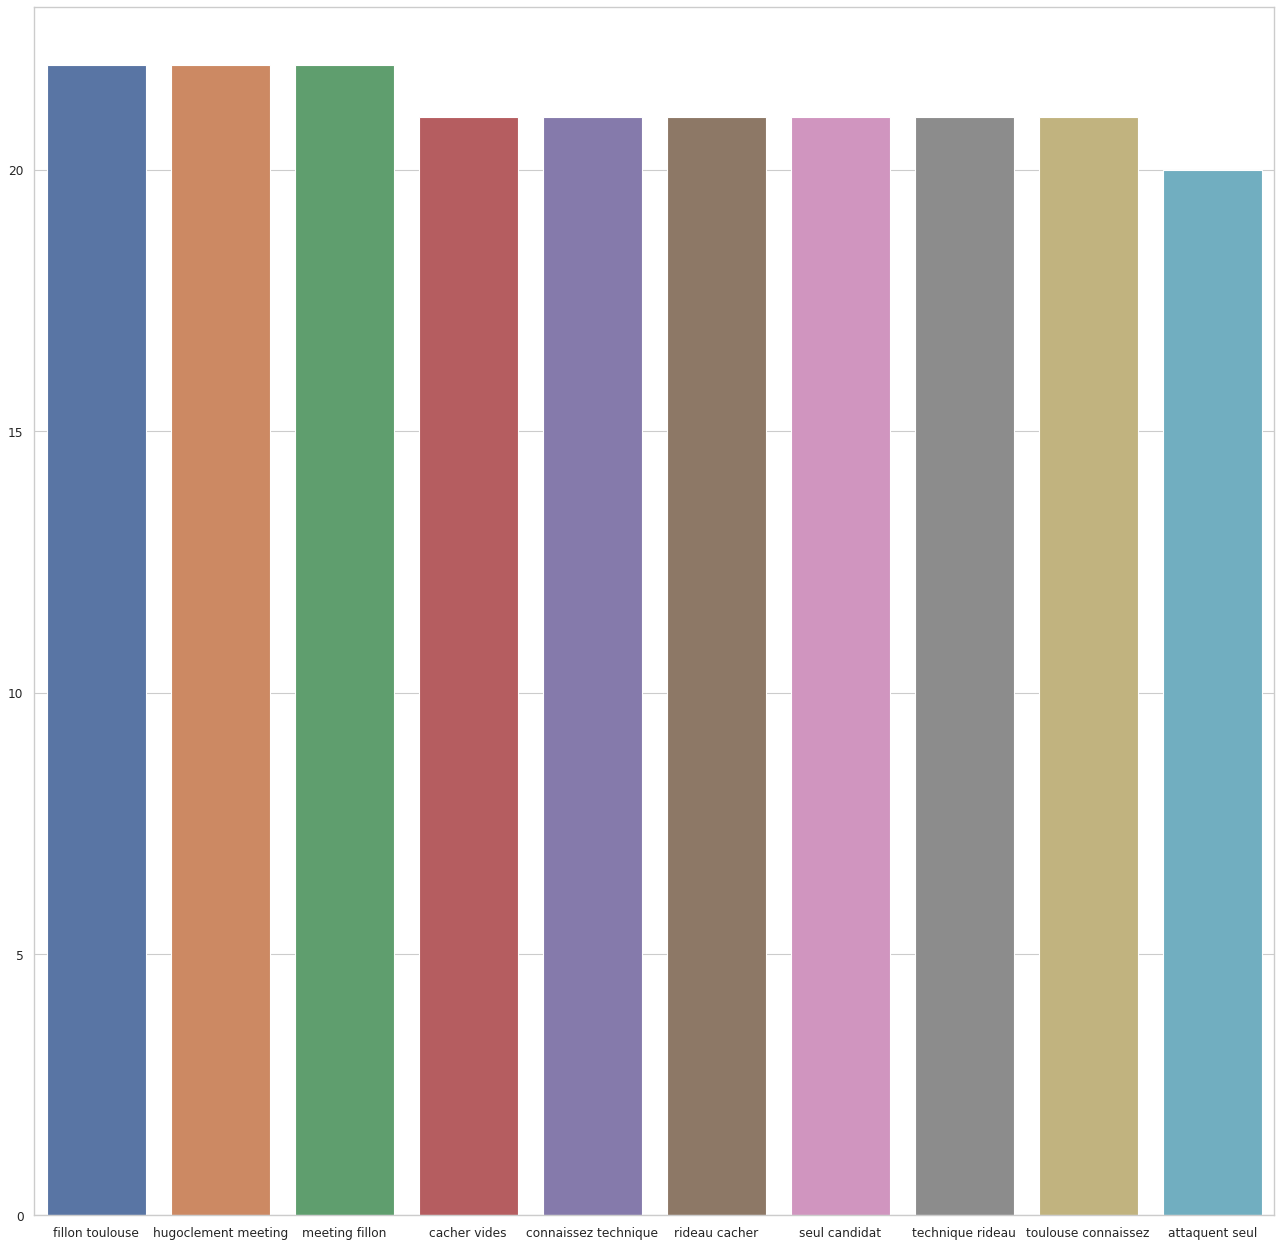

In [6]:
histogramme_vectorised_data(new_tweets,2,k)

# CLASSIFICATION DE TWEETS PAR THEME

# Tweets graph

In [7]:
part_retweets = True
part_figure = True
part_hashtags = True
part_hashtags2 = True

In [8]:
# définition à la main du dictionnaire pour rassembler les hashtags sur un hashtag commun
dict_candidat = {'macron': ['macron', 'EnMarche', 'MacronBercy', 'JeVoteMacron', 'Macron2017'],
                 'fillon': ['fillon', 'Fillon2017', 'JeVoteFillon', 'FillonPresident'],
                 'jlm': ['JLM2017', 'Mélenchon', 'LaForcedupeuple', 'JLMToulouse', 'AuNomDuPeuple', 'FranceInsoumise'],
                 'lepen': ['Marine2017', 'LePen', 'MarineLePen', 'MarineÀParis'],
                 'hamon': ['Hamon2017', 'Hamon']}
index_cand = np.concatenate(list(dict_candidat.values()))
data_cand = ['macron']*5 + ['fillon']*4 + ['jlm']*6 + ['lepen']*4 + ['hamon']*2

In [9]:
# recover data
users = get_dataframe_from_table("users_0415_0423")

Total number of rows in users_0415_0423 is:  681638
MySQL connection is closed


In [36]:
# compute number of tweet per user
tweets = get_dataframe_from_table("tweets_0415_0423",columns = ['tweet_id','user_id'])
tweets['nb_tweets'] = pd.Series(np.ones(tweets.shape[0])).values
tweets_count = tweets[['user_id', 'nb_tweets']].groupby('user_id').count()
users['nb_tweets'] = users.user_id.map(pd.Series(index=tweets_count.index, data=tweets_count.nb_tweets))

Total number of rows in tweets_0415_0423 is:  5414858
MySQL connection is closed


In [37]:
# select users with more than 100 tweets
users_reduced = users[users.nb_tweets > 100]

In [38]:
# recover data about media
media = get_dataframe_from_table("medias_0415_0423")

Total number of rows in medias_0415_0423 is:  644470
MySQL connection is closed


In [39]:
if part_hashtags:
    # recover tweets and hashtags data
    hashs = get_dataframe_from_table("hashs_0415_0423")
    hash_tweets = get_dataframe_from_table("tweet_hash_0415_0423")
    tweets = get_dataframe_from_table("tweets_0415_0423",columns = ['tweet_id','user_id'])

    # add column containing hashtag content in hash_tweets
    hashs['hash_id'] = hashs['hash_id'].apply(int)
    hash_tweets['hash'] = hash_tweets.hash_id.map(pd.Series(index=hashs.hash_id.values, data=hashs.hash.values))

    # on garde les hashtags qui sont dans le dictionnaire défini au début
    hash_tweets = hash_tweets[hash_tweets.hash.isin(np.concatenate(list(dict_candidat.values())))]
    # ajout d'une colonne pour le user qui a écrit le hashtag
    hash_tweets['user_id'] = hash_tweets.tweet_id.map(pd.Series(index = tweets.tweet_id.values, data = tweets.user_id.values))

    # on regroupe les hashtags ( jlm,jlm2017,jlmToulouse ---> jlm)
    hash_tweets['hash_simplified'] = hash_tweets.hash.map(pd.Series(index=index_cand, data=data_cand))

    #on sélectionne les hashtags des users qui ont au moins 100 tweets
    hash_tweets = hash_tweets[hash_tweets.user_id.isin(users_reduced.user_id.values)]
    tmp = hash_tweets[['user_id','hash_simplified']].groupby('user_id').hash_simplified.apply(list)

    #on ajoute une colonne dans la table des users, contenant les hashtags qu'ils ont écrit
    users_reduced['hashtags'] = users_reduced.user_id.map(tmp)
    # calcul de l'entropie
    users_reduced = entropy_hashtags(users_reduced)
    # définition de l'affinité politique
    users_reduced = politic_affinity((users_reduced))

Total number of rows in hashs_0415_0423 is:  48250
MySQL connection is closed
Total number of rows in tweet_hash_0415_0423 is:  4362001
MySQL connection is closed
Total number of rows in tweets_0415_0423 is:  5414858
MySQL connection is closed


/home/ghada/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ghada/Bureau/Codes python/tweeter_project/function/hashtags.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users['hashtag_entropy'] = users.hashtags.apply(lambda x: np.array(x))
/home/ghada/Bureau/Codes python/tweeter_project/function/hashtags.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

23        1.000000
244       0.748327
341       1.322179
456       0.721928
612       1.205161
            ...   
678973    1.248575
679056   -0.000000
679988    1.405993
680012   -0.000000
680154    1.156112
Name: hashtag_entropy, Length: 8095, dtype: float64


In [41]:
if part_retweets:
    # on récupere la table des tweets avec les informations sur les retweets
    tweets = get_dataframe_from_table("tweets_0415_0423",
                                    columns=['tweet_id', 'user_id', 'retweeted_status_id', 'retweeted_user_id'])
    #calcul de nombre de fois qu'une personne est retweetée
    retweeted_count = tweets[['user_id','retweeted_user_id']].groupby('retweeted_user_id').count()
    users_reduced['retweeted_count'] = users_reduced.user_id.map(pd.Series(index=retweeted_count.index, data=retweeted_count.user_id.values))

    #calcul du nombre de fois qu'un user retweet
    retweeter_count = tweets[~tweets.retweeted_user_id.isin([None])][['user_id','retweeted_user_id']].groupby('user_id').count()
    users_reduced['retweeter_count'] = users_reduced.user_id.map(pd.Series(index=retweeter_count.index, data=retweeter_count.retweeted_user_id.values))

    users_reduced = users_reduced.astype(object).replace('None',0) # on remplace les np.nan par des None
    users_reduced = users_reduced.astype(object).replace(np.nan,0) # on remplace les np.nan par des None

    # partitionnement par rapport aux nb tweets, retweeted/retweeter count en utilisant KMeans
    users_reduced['cluster_id'] = supervised(users_reduced,['nb_tweets','retweeter_count','retweeted_count'])

Total number of rows in tweets_0415_0423 is:  5414858
MySQL connection is closed


/home/ghada/Bureau/Codes python/tweeter_project/function/figure.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  num_of_tweets = num_of_tweets[users.nb_tweets >= paliers[i]].shape[0]


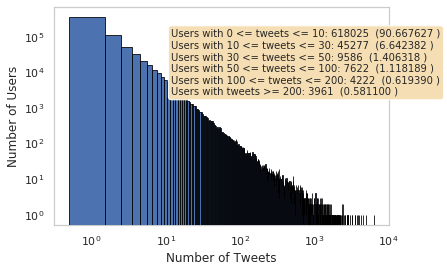

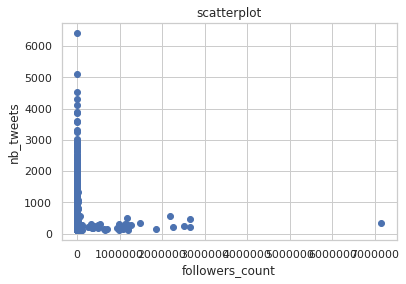

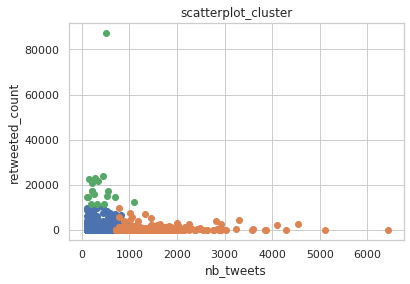

In [42]:
if part_figure:
    hist_user_tweet(users)
    scatterplot(users_reduced,'followers_count','nb_tweets',title='scatterplot',filename='nb_foll_nb_tweets_scatter')
    scatterplot_cluster(users_reduced,'nb_tweets','retweeted_count',title='scatterplot_cluster',filename='cluster_nb_tweets_retweeted_scatter')
    # on écrit le fichier de graphe des retweets
    write_retweets_gml(tweets, users_reduced)
    G = nx.read_gml('./data/retweets1.gml',label=None)
    partition = community.best_partition(G)
    users_reduced['louvain'] = users_reduced.user_id.map(pd.Series(index = list(partition.keys()),data = list(partition.values())))



In [43]:
users_final = users_reduced[~users_reduced.louvain.isin([np.nan])]

In [9]:
def hist_hashtags(df,filename = None):
    """calcule l'hist des hashtags pour une df"""
    flatten = lambda l: [item for sublist in l for item in sublist]
    hashtags = pd.Series(flatten(list(df.hashtag_origin.values)))
    hist = hashtags.value_counts()[:15].plot(kind='bar')
    hist.set_xticklabels(hist.get_xticklabels(), rotation=45, horizontalalignment='right')
    if filename is not None:
        plt.savefig('./figures/%s.pdf'%filename,bbox_inches='tight')

def moy_hashtag(df,hashtag):
    """calcule la fréquence d'apparation du hashtags dans les tweets pour chaque user"""
    bool_hash = df.hashtag_origin.apply(lambda x: hashtag in x)
    bool_hash = bool_hash[bool_hash == True]
    res = len(bool_hash)/len(df)
    return res



In [45]:
if part_hashtags2:
    # recover tweets and hashtags data
    hashs = get_dataframe_from_table("hashs_0415_0423")
    hash_tweets = get_dataframe_from_table("tweet_hash_0415_0423")
    tweets = get_dataframe_from_table("tweets_0415_0423",columns = ['tweet_id','user_id'])

    # add column containing hashtag content in hash_tweets
    hashs['hash_id'] = hashs['hash_id'].apply(int)
    hash_tweets['hash'] = hash_tweets.hash_id.map(pd.Series(index=hashs.hash_id.values, data=hashs.hash.values))

    # ajout d'une colonne pour le user qui a écrit le hashtag
    hash_tweets['user_id'] = hash_tweets.tweet_id.map(pd.Series(index = tweets.tweet_id.values, data = tweets.user_id.values))

    #on sélectionne les hashtags des users qui ont au moins 100 tweets
    hash_tweets = hash_tweets[hash_tweets.user_id.isin(users_final.user_id.values)]
    tmp = hash_tweets[['user_id','hash']].groupby('user_id').hash.apply(list)

    #on ajoute une colonne dans la table des users, contenant les hashtags qu'ils ont écrit
    users_final['hashtag_origin'] = users_reduced.user_id.map(tmp)


    contre_fillon = users_final[users_final.louvain == 0]
    pour_macron = users_final[users_final.louvain == 1]
    contre_macron = users_final[users_final.louvain == 4][users_final.politic_affinity== 'macron']
    pour_fillon = users_final[users_final.louvain == 4][users_final.politic_affinity== 'fillon']

Total number of rows in hashs_0415_0423 is:  48250
MySQL connection is closed
Total number of rows in tweet_hash_0415_0423 is:  4362001
MySQL connection is closed
Total number of rows in tweets_0415_0423 is:  5414858
MySQL connection is closed


/home/ghada/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ghada/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/ghada/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


# latent semantic analysis

# Gensim

In [10]:
import os.path
from gensim import corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel
from gensim import models

In [11]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    corpus  = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,corpus 

In [12]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    terms,corpus=prepare_corpus(doc_clean)
    # generate LSA model
    
    tfidf = models.TfidfModel(corpus) 
    corpus_tfidf = tfidf[corpus]
    lsi_model= models.LsiModel(corpus_tfidf, id2word=terms, num_topics=number_of_topics)
    print(lsi_model.print_topics(num_topics=number_of_topics, num_words=words))
    return lsi_model  

In [13]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [14]:
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

In [15]:
clean_txt=[txt.split() for txt in new_tweets]
from collections import defaultdict
# remove words that appear only once
frequency = defaultdict(int)
for text in clean_txt:
    for token in text:
        frequency[token] += 1
clean_txts= [[token for token in text if frequency[token] > 1]
    for text in clean_txt]


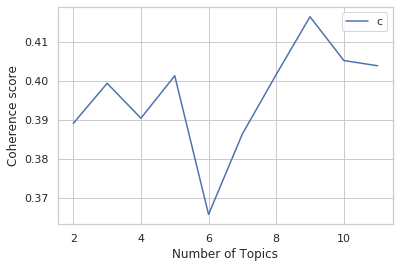

In [18]:
start,stop,step=2,12,1
number_of_topics=7
plot_graph(clean_txts,start,stop,step)

In [19]:
model=create_gensim_lsa_model(clean_txts,10,5)

[(0, '-0.355*"rideau" + -0.354*"vides" + -0.353*"cacher" + -0.352*"connaissez" + -0.348*"hugoclement"'), (1, '0.729*"jamais" + 0.382*"ment" + 0.379*"trois" + 0.373*"autres" + 0.172*"fillon"'), (2, '-0.429*"recevons" + -0.426*"associations" + -0.423*"ONG" + -0.390*"tous" + -0.389*"programme"'), (3, '0.653*"youssefbarcaa" + 0.648*"CAF" + 0.344*"macron" + -0.070*"recevons" + -0.069*"associations"'), (4, '-0.433*"flash" + -0.429*"leuohh" + -0.428*"demande" + -0.425*"rendre" + -0.425*"nord"'), (5, '-0.611*"peuple" + -0.329*"ressemble" + -0.326*"attaquent" + -0.324*"disent" + -0.320*"comprendre"'), (6, '-0.365*"hamon" + -0.348*"marine" + -0.311*"banlieue" + -0.309*"parce" + -0.307*"pen"'), (7, '-0.610*"undzkitwitte" + -0.605*"regarde" + -0.238*"fillon" + 0.188*"hamon" + 0.177*"marine"'), (8, '-0.368*"macron" + -0.331*"voter" + -0.266*"nocturne" + -0.241*"emmanuel" + -0.178*"deja"'), (9, '-0.389*"jlmelenchon" + -0.363*"dimanche" + 0.328*"nocturne" + 0.233*"deja" + 0.233*"gblardone"')]


In [70]:
dict_candidat = {'0': ['macron', 'EnMarche', 'MacronBercy', 'JeVoteMacron', 'Macron2017'],
                 '1': ['fillon', 'Fillon2017', 'JeVoteFillon', 'FillonPresident'],
                 '2': ['jlmelenchon','JLM2017', 'Mélenchon', 'LaForcedupeuple', 'JLMToulouse', 'AuNomDuPeuple', 'FranceInsoumise','JLM','jlm'],
                 '3': ['Marine2017', 'LePen', 'MarineLePen', 'MarineÀParis','LEPEN'],
                 '4': ['Hamon2017', 'Hamon']}
liste=np.zeros((len(clean_txts),5))
for i in range(len(clean_txts)):
    for word in clean_txts[i]:
        for key in dict_candidat.keys():
            if word in dict_candidat[key]:
                liste[i][int(key)]+=1
tweets_candidat=[0 for i in range(5)]
for i in range(len(liste)):
    tweets_candidat[np.argmax(liste[i])]+=1

# SIKITLEARN

In [25]:
vectorizer = TfidfVectorizer(stop_words=french_stop_words, max_features= 500, max_df = 0.5, smooth_idf=True)
X = vectorizer.fit_transform(new_tweets)
n_topics=10
svd_model = TruncatedSVD(n_components=n_topics, algorithm='randomized', n_iter=100, random_state=122)
svd_model.fit(X)

TruncatedSVD(algorithm='randomized', n_components=10, n_iter=100,
             random_state=122, tol=0.0)

In [26]:
terms = vectorizer.get_feature_names()
Topics=[0 for i in range(n_topics)]

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    for t in sorted_terms:
        Topics.append(t[0])

/home/ghada/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/home/ghada/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)
  n_components


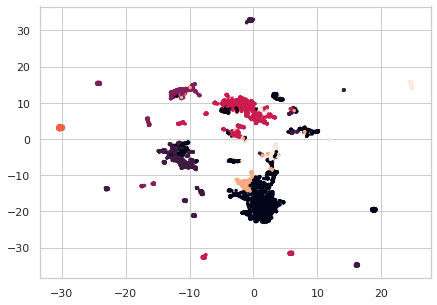

In [27]:
num_clusters = 7
km = KMeans(n_clusters=num_clusters)
km.fit(X)
clusters = km.labels_.tolist()
X_topics = svd_model.fit_transform(X)
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(X_topics)
plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1],c=clusters,s = 6)
plt.show()


# SENTIMENT ANALYSIS

# MANUAL LABELS

In [4]:
sentiment_value=[None for i in range(len(new_tweets))]
tweets_to_be_treated={'text':new_tweets,'sentiment':sentiment_value}
tweets_for_sentiment_analysis=pd.DataFrame(tweets_to_be_treated)
sentiment_labels=[-1,-1,-1,0,-1,-1,-1,-1,1,0,-1,-1,-1,-1,0,0,1,1,-1,-1,-1,-1,-1,-1,0,-1,1,0,-1,1,1,1,-1,-1,-1,-1,0,-1,0,0,1,0,1,1,1,-1,-1,0,-1,0,-1,-1,0,1,0,1,-1,-1,1,-1,1,1,-1,0,-1,0,1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,-1,-1,-1,-1,0,-1,1,-1,0,0,-1,-1,-1,-1,-1,1,1,-1,0,1,1,-1,-1,1,-1,-1,1,1,-1,-1,1,-1,0,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,1,1,-1,1,1,-1,1,-1,1,-1,1,1,-1,1,1,-1,1,1,0,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,0,-1,-1,0,1,1,-1,-1,-1,-1,-1,-1,0,-1,1,-1,-1,-1,-1,1,0,-1,-1,0,0,-1,1,-1,1,-1,-1,1,1,-1,-1,1,-1,0,-1,-1,-1,0,1,1,-1,-1,1,1,0,-1,1,1,1]
for i in range(len(sentiment_labels)):
    tweets_for_sentiment_analysis['sentiment'][i]=sentiment_labels[i]

# EMOTICONS

In [5]:
emoticons_happy = set([':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D','=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P','x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)','<3'])
emoticons_sad = set([':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',':c', ':{', '>:\\', ';('])
emoticons = emoticons_happy.union(emoticons_sad)

In [6]:
emoticon_presence_index=[]
for i in range(len(data)):
    for e in emoticons:
        if e in data['text'][i]:
            if e in emoticons_happy:
                emoticon_presence_index.append((i,1))
            else:
                emoticon_presence_index.append((i,-1))

for index_sentiment in emoticon_presence_index:
    index=index_sentiment[0]
    value=index_sentiment[1]
    tweets_for_sentiment_analysis['sentiment'][index]=value

# FOR/AGAINST POLITICIANS

In [7]:
import string
string.punctuation=string.punctuation+'»...'
terms_hash=[term.replace('#','') for i in range(len(data)) for term in data['text'][i].split() if term.startswith('#')]
hashtag_without_ponctuation=[]
for word in terms_hash:
    hashtag_without_ponctuation.append(word.translate(str.maketrans("","", string.punctuation)))

In [8]:
cnt=Counter()
H=[]
hashtag_occurence=Counter(hashtag_without_ponctuation).most_common(20)
for i in range(len(hashtag_occurence)):
    couple=hashtag_occurence[i]
    for j in range(couple[1]):
        H.append(couple[0])
    
hashs={'hash':H}
hashtag=pd.DataFrame(hashs)

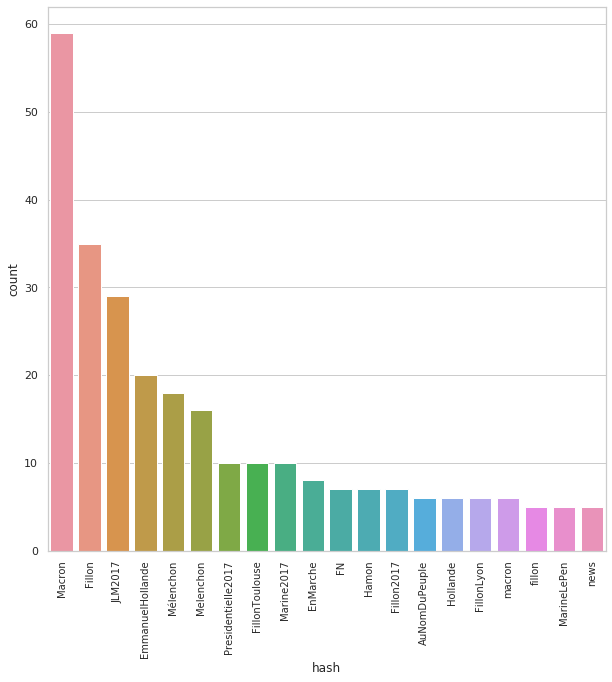

In [9]:
labels = hashtag["hash"].value_counts().keys()
plt.figure(figsize=(10,10))
ax = sns.countplot(x="hash", data=hashtag,order = hashtag["hash"].value_counts().index)
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=90)
plt.xticks(fontsize=10)
plt.show()

In [10]:
dict_candidat = {'macron': ['EnMarche', 'MacronBercy', 'JeVoteMacron', 'macron2017'],
                 'fillon': ['Fillon2017', 'JeVoteFillon', 'FillonPresident'],
                 'jlm': ['JLM2017', 'Mélenchon', 'LaForcedupeuple', 'JLMToulouse', 'AuNomDuPeuple', 'FranceInsoumise'],
                 'lepen': ['Marine2017', 'LePen', 'MarineLePen', 'MarineÀParis'],
                 'hamon': ['Hamon2017']}
candidats=dict_candidat.keys()
for term in hashtag_without_ponctuation:
    for key in candidats:
        term=term.lower()
        if term.find(key)!=-1 and term not in dict_candidat[key]:
            dict_candidat[key].append(term)

In [11]:
FOR=['EnMarche', 'MacronBercy', 'JeVoteMacron', 'macron2017','Fillon2017', 'JeVoteFillon','Marine2017', 'LePen', 'MarineLePen', 'MarineÀParis','FillonPresident','filliontoulouse','fillonment0','projetfillion','FuturDesirable']
AGAINST=['macronbesancon','stoparnaquemacron','macronpau','stopmacron','rendlargent']

In [15]:
for i in range(len(sentiment_labels),len(tweets_for_sentiment_analysis)):
    if tweets_for_sentiment_analysis['sentiment'][i] == None :
        for word in FOR:
            if tweets_for_sentiment_analysis['text'][i].find(word)!=-1:
                tweets_for_sentiment_analysis['sentiment'][i]=1
                break
        for word in AGAINST:
            if tweets_for_sentiment_analysis['text'][i].find(word)!=-1:
                tweets_for_sentiment_analysis['sentiment'][i]=-1
                break            

In [36]:
none_values=tweets_for_sentiment_analysis[(tweets_for_sentiment_analysis['sentiment'] != 1) & ( tweets_for_sentiment_analysis['sentiment']!= 0) & (tweets_for_sentiment_analysis['sentiment'] != -1)]

In [37]:
data_top = none_values.head(464)  
rows=[]
# iterating the columns 
for row in data_top.index: 
    rows.append(row)

In [83]:
from sklearn.model_selection import train_test_split 
tweets_for_classif=tweets_for_sentiment_analysis[(tweets_for_sentiment_analysis['sentiment'] == 1) | (tweets_for_sentiment_analysis['sentiment'] == -1)]
train, test = train_test_split(tweets_for_classif,test_size = 0.4)
# Removing neutral sentiments
train = train[train.sentiment != 0]
train_pos = train[ train['sentiment'] == 1]
train_pos = train_pos['text']
train_neg = train[ train['sentiment'] == -1]
train_neg = train_neg['text']


In [84]:
from wordcloud import WordCloud

Positive words


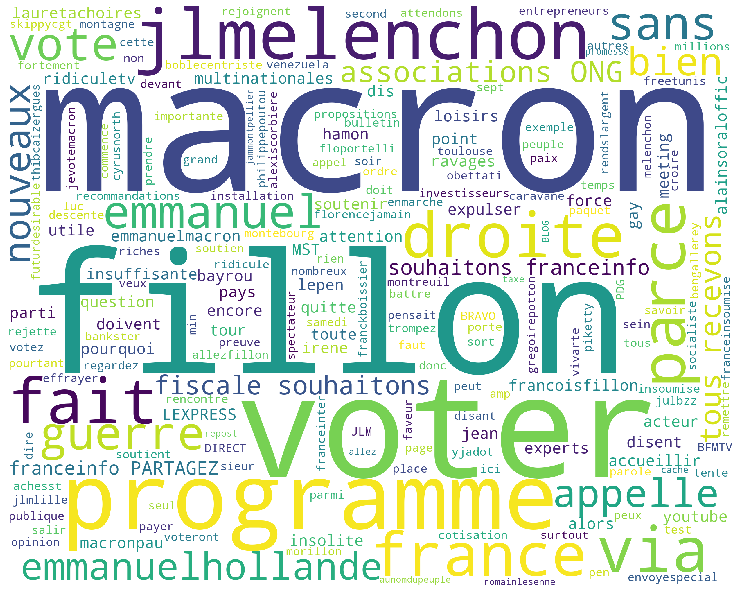

Negative words


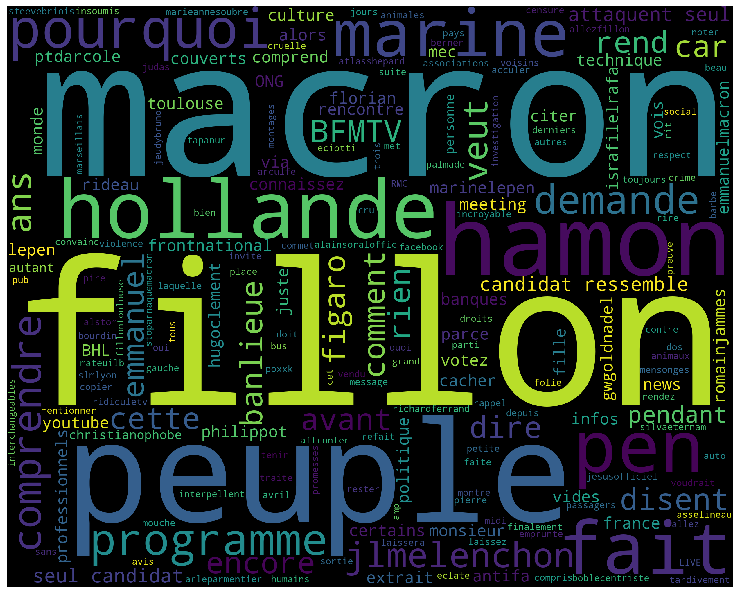

In [85]:
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=french_stop_words,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive words")
wordcloud_draw(train_pos,'white')
print("Negative words")
wordcloud_draw(train_neg)

In [86]:
tweets = []
stopwords_set = set(french_stop_words)

for index, row in train.iterrows():
    words_filtered = [e.lower() for e in row.text.split() if len(e) >= 3]
    words_cleaned = [word for word in words_filtered
        if 'http' not in word
        and not word.startswith('@')
        and not word.startswith('#')
        and word != 'RT']
    words_without_stopwords = [word for word in words_cleaned if not word in stopwords_set]
    tweets.append((words_without_stopwords, row.sentiment))

test_pos = test[ test['sentiment'] == 1]
test_pos = test_pos['text']
test_neg = test[ test['sentiment'] == -1]
test_neg = test_neg['text']

In [87]:
def get_words_in_tweets(tweets):
    all = []
    for (words, sentiment) in tweets:
        all.extend(words)
    return all

def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    features = wordlist.keys()
    return features

w_features = get_word_features(get_words_in_tweets(tweets))


def extract_features(document):
    document_words = set(document)
    features = {}
    for word in w_features:
        features['contains(%s)' % word] = (word in document_words)
    return features

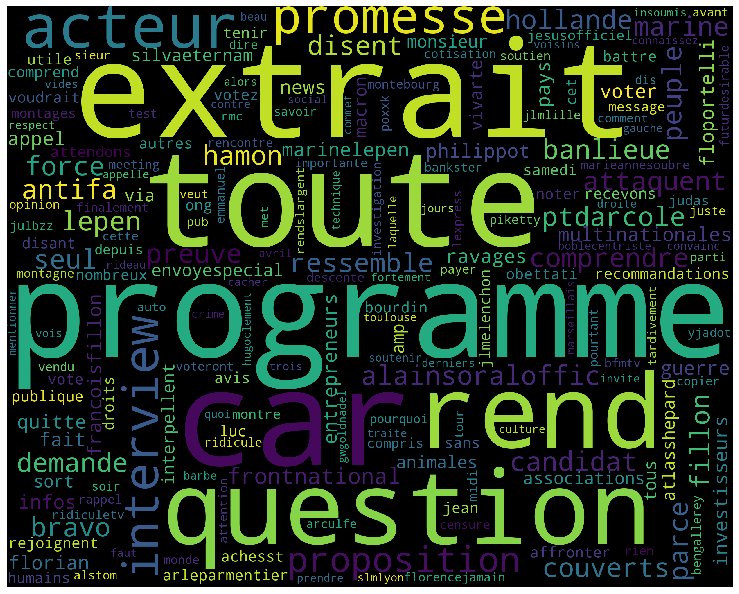

In [88]:
wordcloud_draw(w_features)


In [89]:
# Training the Naive Bayes classifier
training_set = nltk.classify.apply_features(extract_features,tweets)
classifier = nltk.NaiveBayesClassifier.train(training_set)

In [90]:
neg_cnt = 0
pos_cnt = 0

for obj in test_neg: 
    res =  classifier.classify(extract_features(obj.split()))
    if(res == -1): 
        neg_cnt = neg_cnt + 1
for obj in test_pos: 
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 1): 
        pos_cnt = pos_cnt + 1
        
print('[Negative]: %s/%s '  % (len(test_neg),neg_cnt))        
print('[Positive]: %s/%s '  % (len(test_pos),pos_cnt))

[Negative]: 52/31 
[Positive]: 30/19 
